In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

In [31]:
class ACGANGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_channels):
        super(ACGANGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.img_channels = img_channels
        
        # Input: latent_dim + num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.BatchNorm1d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(1024, img_channels * 64 * 64),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate noise and labels
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), self.img_channels, 64, 64)
        return img


In [32]:
class ACGANDiscriminator(nn.Module):
    def __init__(self, img_channels, num_classes):
        super(ACGANDiscriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(img_channels * 64 * 64, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128, num_classes), nn.Softmax(dim=1))

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        features = self.model(img_flat)
        
        # Discriminator output: real/fake
        validity = self.adv_layer(features)
        
        # Auxiliary output: class labels
        label = self.aux_layer(features)

        return validity, label


In [33]:
# Hyperparameters
latent_dim = 100
num_classes = 6
img_channels = 3
learning_rate = 0.0002
batch_size = 76

# Initialize generator and discriminator
generator = ACGANGenerator(latent_dim, num_classes, img_channels)
discriminator = ACGANDiscriminator(img_channels, num_classes)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Loss functions
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()

In [38]:
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image

In [39]:
# Define the custom dataset to load and preprocess images
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, subfolders, transform=None):
        self.base_dir = base_dir
        self.subfolders = subfolders
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder)
            label = subfolder

            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)
        
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# Define the base directory and subfolders
base_dir = r'DIAT-uSAT_dataset'
subfolders = [
    r"3_long_blade_rotor", 
    r"3_short_blade_rotor", 
    r"Bird", 
    r"Bird+mini-helicopter", 
    r"drone", 
    r"rc_plane", 
]

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize images to [-1, 1]
])


In [48]:
# Load dataset
dataset = CustomImageDataset(base_dir, subfolders, transform=transform)
dataloader = DataLoader(dataset, batch_size=76, shuffle=True)


In [49]:
import torch

# Initialize best generator and discriminator loss
best_g_loss = float('inf')  # Best generator loss
best_d_loss = float('inf')  # Best discriminator loss

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to the correct device (CPU or GPU)
generator.to(device)
discriminator.to(device)

# Number of epochs
num_epochs = 100

# Training loop
for epoch in range(num_epochs):
    total_g_loss = 0.0
    total_d_loss = 0.0
    num_batches = len(dataloader)
    
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.size(0)
        
        # Move images and labels to the correct device
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # Create labels for real and fake data
        valid = torch.ones((batch_size, 1), requires_grad=False).to(device)
        fake = torch.zeros((batch_size, 1), requires_grad=False).to(device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate random noise and labels for generator input
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)

        # Generate images using the generator
        gen_imgs = generator(z, gen_labels)
        
        # Get predictions from the discriminator for fake images
        validity, pred_label = discriminator(gen_imgs)

        # Calculate generator loss (adversarial + auxiliary loss)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))
        
        # Backpropagate and update generator weights
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Train on real images
        real_pred, real_aux = discriminator(imgs)
        d_real_loss = 0.5 * (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels))

        # Train on fake images (generated by the generator)
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = 0.5 * (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels))

        # Total discriminator loss (average of real and fake loss)
        d_loss = (d_real_loss + d_fake_loss) / 2
        
        # Backpropagate and update discriminator weights
        d_loss.backward()
        optimizer_D.step()

        # Accumulate losses
        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

    # Calculate average losses for the epoch
    avg_g_loss = total_g_loss / num_batches
    avg_d_loss = total_d_loss / num_batches

    # Print the average losses per epoch
    print(f"[Epoch {epoch+1}/{num_epochs}] [D loss: {avg_d_loss:.4f}] [G loss: {avg_g_loss:.4f}]")

    # Save the generator if the current epoch's generator loss is the lowest
    if avg_g_loss < best_g_loss:
        best_g_loss = avg_g_loss
        torch.save(generator.state_dict(), "best_generator_model.pt")  # Save best generator

    # Save the discriminator if the current epoch's discriminator loss is the lowest
    if avg_d_loss < best_d_loss:
        best_d_loss = avg_d_loss
        torch.save(discriminator.state_dict(), "best_discriminator_model.pt")  # Save best discriminator


[Epoch 1/100] [D loss: 0.8848] [G loss: 0.9715]
[Epoch 2/100] [D loss: 0.8802] [G loss: 0.9942]
[Epoch 3/100] [D loss: 0.8859] [G loss: 1.0256]
[Epoch 4/100] [D loss: 0.8786] [G loss: 0.9969]
[Epoch 5/100] [D loss: 0.8740] [G loss: 1.0088]
[Epoch 6/100] [D loss: 0.8823] [G loss: 0.9866]
[Epoch 7/100] [D loss: 0.8781] [G loss: 0.9980]
[Epoch 8/100] [D loss: 0.8745] [G loss: 0.9771]
[Epoch 9/100] [D loss: 0.8714] [G loss: 0.9943]
[Epoch 10/100] [D loss: 0.8806] [G loss: 0.9980]
[Epoch 11/100] [D loss: 0.8736] [G loss: 0.9791]
[Epoch 12/100] [D loss: 0.8718] [G loss: 0.9941]
[Epoch 13/100] [D loss: 0.8677] [G loss: 0.9974]
[Epoch 14/100] [D loss: 0.8729] [G loss: 0.9768]
[Epoch 15/100] [D loss: 0.8713] [G loss: 0.9970]
[Epoch 16/100] [D loss: 0.8724] [G loss: 0.9979]
[Epoch 17/100] [D loss: 0.8776] [G loss: 0.9863]
[Epoch 18/100] [D loss: 0.8739] [G loss: 0.9804]
[Epoch 19/100] [D loss: 0.8755] [G loss: 0.9860]
[Epoch 20/100] [D loss: 0.8697] [G loss: 0.9866]
[Epoch 21/100] [D loss: 0.870

Generator is on device: cuda:0
Noise is on device: cuda:0
Labels are on device: cuda:0
Generated images shape: torch.Size([6, 3, 64, 64])
Grid shape: torch.Size([3, 68, 398])


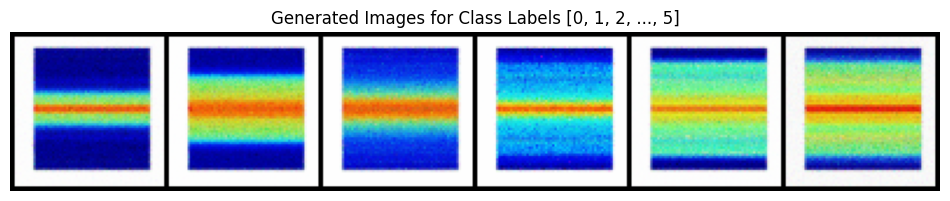

In [50]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def test_generator(generator, num_classes, latent_dim, device):
    # Set the generator to evaluation mode
    generator.eval()
    
    # Generate random noise and class labels
    z = torch.randn(num_classes, latent_dim).to(device)  # Generate noise
    labels = torch.arange(num_classes).to(device)  # Class labels [0, 1, 2, ..., num_classes-1]
    
    # Move the generator to the specified device (if it's not already there)
    generator = generator.to(device)
    
    # Debugging: Check the device
    print(f"Generator is on device: {next(generator.parameters()).device}")
    print(f"Noise is on device: {z.device}")
    print(f"Labels are on device: {labels.device}")
    
    # Generate images
    with torch.no_grad():  # No need to compute gradients during testing
        gen_imgs = generator(z, labels)
    
    # Debugging: Print shape of generated images
    print(f"Generated images shape: {gen_imgs.shape}")
    
    # Unnormalize the images from [-1, 1] back to [0, 1] for visualization
    gen_imgs = (gen_imgs + 1) / 2.0
    
    # Create a grid of images and display them
    grid = make_grid(gen_imgs.cpu(), nrow=num_classes, normalize=False)
    
    # Debugging: Check grid shape
    print(f"Grid shape: {grid.shape}")
    
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"Generated Images for Class Labels [0, 1, 2, ..., {num_classes-1}]")
    plt.axis("off")
    plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_generator(generator, num_classes=6, latent_dim=100, device=device)

In [52]:
import torch

def test_discriminator(discriminator, generator, dataloader, num_classes, latent_dim, device):
    # Set the models to evaluation mode
    discriminator = discriminator.to(device)  # Move discriminator to the correct device
    generator = generator.to(device)  # Move generator to the correct device
    
    discriminator.eval()
    generator.eval()

    # Initialize lists to store accuracy for real and fake images
    real_accuracy = 0
    fake_accuracy = 0
    class_accuracy = 0
    total_samples = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            batch_size = imgs.size(0)
            total_samples += batch_size

            imgs = imgs.to(device)
            labels = labels.to(device)
            real_pred, real_aux = discriminator(imgs)
            real_accuracy += (real_pred > 0.5).float().mean().item()  # Binary classification for real/fake
            class_accuracy += (real_aux.argmax(dim=1) == labels).float().mean().item()  # Class accuracy

            # Fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
            gen_imgs = generator(z, gen_labels)

            fake_pred, fake_aux = discriminator(gen_imgs)
            fake_accuracy += (fake_pred < 0.5).float().mean().item()  # Fake should be classified as 0 (fake)
            class_accuracy += (fake_aux.argmax(dim=1) == gen_labels).float().mean().item()

    # Calculate average accuracies
    real_accuracy /= len(dataloader)
    fake_accuracy /= len(dataloader)
    class_accuracy /= (2 * len(dataloader))  # Since class accuracy is measured for both real and fake

    print(f"Discriminator Real Accuracy: {real_accuracy * 100:.2f}%")
    print(f"Discriminator Fake Accuracy: {fake_accuracy * 100:.2f}%")
    print(f"Discriminator Class Accuracy: {class_accuracy * 100:.2f}%")

# Example usage 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_discriminator(discriminator, generator, dataloader, num_classes=6, latent_dim=100, device=device)



Discriminator Real Accuracy: 56.96%
Discriminator Fake Accuracy: 80.26%
Discriminator Class Accuracy: 94.37%


In [56]:
import os
import torch
import torchvision.transforms as transforms

def generate_synthetic_dataset(generator, num_samples_per_class, class_names, latent_dim, output_dir, device):
    generator.eval()  # Set the generator to evaluation mode
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
    
    synthetic_images = []  # List to store generated images
    synthetic_labels = []  # List to store corresponding labels

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)  # Create a subfolder for each class

        for sample_idx in range(num_samples_per_class):
            # Generate latent vector and label
            z = torch.randn(1, latent_dim).to(device)  # Generate a random latent vector
            label = torch.tensor([class_idx]).to(device)  # Assign the current class label

            with torch.no_grad():
                synthetic_img = generator(z, label)  # Generate the synthetic image

            # Unnormalize the image from [-1, 1] back to [0, 1]
            synthetic_img = (synthetic_img + 1) / 2.0

            # Convert the tensor to a PIL image for saving
            img = transforms.ToPILImage()(synthetic_img.squeeze(0).cpu())

            # Save the image as Figure{sample_idx + 1}.jpg
            img.save(os.path.join(class_dir, f'Figure{sample_idx + 1}.jpg'))

            # Append the generated image and label to the lists
            synthetic_images.append(synthetic_img.squeeze(0))  # Remove the batch dimension
            synthetic_labels.append(label)

    # Convert lists to tensors
    synthetic_images_tensor = torch.stack(synthetic_images)
    synthetic_labels_tensor = torch.cat(synthetic_labels)  # Concatenate labels into a single tensor

    print(f"Synthetic dataset generated and saved in: {output_dir}")
    
    return synthetic_images_tensor, synthetic_labels_tensor  # Return generated images and labels

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = "synthetic_dataset"  # Specify the directory where you want to save the dataset
class_names = ["3_long_blade_rotor", "3_short_blade_rotor", "Bird", "Bird+mini-helicopter", "drone", "rc_plane"]

synthetic_images, synthetic_labels = generate_synthetic_dataset(
    generator,
    num_samples_per_class=200,
    class_names=class_names,
    latent_dim=100,
    output_dir=output_dir,
    device=device
)

# Check the shapes of the returned tensors
print(f"Synthetic Images Shape: {synthetic_images.shape}")  # Should be (num_samples_per_class * num_classes, img_channels, height, width)
print(f"Synthetic Labels Shape: {synthetic_labels.shape}")  # Should be (num_samples_per_class * num_classes,)


Synthetic dataset generated and saved in: synthetic_dataset
Synthetic Images Shape: torch.Size([1200, 3, 64, 64])
Synthetic Labels Shape: torch.Size([1200])


In [15]:
import torch
import torch.nn as nn

# Define the ACGAN Generator
class ACGANGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_channels):
        super(ACGANGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # Define the layers of the generator
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, img_channels * 64 * 64),
            nn.Tanh()  # Assuming output images are normalized to [-1, 1]
        )

    def forward(self, z, labels):
        label_embedding = self.label_embedding(labels)
        z = torch.cat([z, label_embedding], dim=1)
        img = self.model(z)
        img = img.view(-1, 3, 64, 64)  # Reshape to image format (batch_size, channels, height, width)
        return img


In [16]:
# Function to generate synthetic data
def generate_synthetic_data(generator, num_samples, num_classes, latent_dim, device):
    generator.eval()  # Set generator to evaluation mode
    
    z = torch.randn(num_samples, latent_dim).to(device)  # Generate latent vectors
    labels = torch.randint(0, num_classes, (num_samples,)).to(device)  # Random class labels

    with torch.no_grad():
        synthetic_imgs = generator(z, labels)  # Generate synthetic images
    
    return synthetic_imgs, labels  # Return generated images and corresponding labels


In [17]:
# Define the Attention Model
class AttentionModel(nn.Module):
    def __init__(self, num_classes):
        super(AttentionModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.attention1 = nn.MultiheadAttention(embed_dim=32, num_heads=2)  # Adjusted number of heads
        self.fc = nn.Linear(32 * 64 * 64, num_classes)  # Adjusted input size for fully connected layer

    def forward(self, x):
        # Convolutional layer
        x = F.relu(self.conv1(x))  # Shape: (batch_size, 32, 64, 64)

        # Reshape for attention layer
        batch_size, channels, height, width = x.size()
        x = x.reshape(batch_size, channels, height * width)  # Shape: (batch_size, channels, height * width)

        # Apply MultiheadAttention
        x = x.permute(2, 0, 1)  # Shape: (height * width, batch_size, channels)
        x, _ = self.attention1(x, x, x)  # Using the same tensor for key and value

        # Reshape back to (batch_size, channels, height, width)
        x = x.permute(1, 2, 0).reshape(batch_size, channels, height, width)  # Shape: (batch_size, channels, height, width)

        # Flatten for fully connected layer
        x = x.reshape(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x



In [21]:
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

# Training function
def train_attention_model(model, dataloader, num_epochs, device, accumulation_steps=4, save_path="best_model_CustomVGGWithAttention.pt"):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scaler = GradScaler()  # For mixed precision training
    best_loss = float('inf')  # Initialize with a high loss

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        num_batches = len(dataloader)

        for i, (imgs, labels) in enumerate(dataloader):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss = loss / accumulation_steps  # Scale the loss

            scaler.scale(loss).backward()  # Backpropagate the scaled loss

            # Update the model parameters after accumulating gradients
            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)  # Update model parameters
                scaler.update()  # Update the scaler
                optimizer.zero_grad()  # Reset gradients for the next accumulation step

            total_loss += loss.item() * accumulation_steps  # Adjust total loss for scaled loss

        # Calculate average loss for the epoch
        avg_loss = total_loss / num_batches
        print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), save_path)

        torch.cuda.empty_cache()  # Clear cache after each epoch


In [58]:
# Example usage
latent_dim = 100
num_classes = 6
img_channels = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the generator
generator = ACGANGenerator(latent_dim, num_classes, img_channels).to(device)

# Generate synthetic data
num_samples = 1000
synthetic_imgs, synthetic_labels = generate_synthetic_data(generator, num_samples, num_classes, latent_dim, device)

# Create DataLoader for the synthetic dataset
batch_size = 4  # Set batch size to 4
synthetic_dataset = TensorDataset(synthetic_imgs, synthetic_labels)
synthetic_dataloader = DataLoader(synthetic_dataset, batch_size=batch_size, shuffle=True)

# Initialize and train the attention model
attention_model = AttentionModel(num_classes=num_classes).to(device)
num_epochs = 50

# Train and save the best model
train_attention_model(attention_model, synthetic_dataloader, num_epochs, device)


C:\Users\Shravya H Jain\AppData\Local\Temp\ipykernel_8116\2251689649.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training
C:\Users\Shravya H Jain\AppData\Local\Temp\ipykernel_8116\2251689649.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 1/50] Loss: 2.2111
[Epoch 2/50] Loss: 1.8527
[Epoch 3/50] Loss: 1.8476
[Epoch 4/50] Loss: 1.8584
[Epoch 5/50] Loss: 1.8387
[Epoch 6/50] Loss: 1.8365
[Epoch 7/50] Loss: 1.8242
[Epoch 8/50] Loss: 1.9464
[Epoch 9/50] Loss: 1.9166
[Epoch 10/50] Loss: 1.8627
[Epoch 11/50] Loss: 1.8723
[Epoch 12/50] Loss: 1.9411
[Epoch 13/50] Loss: 1.9180
[Epoch 14/50] Loss: 1.8426
[Epoch 15/50] Loss: 1.8449
[Epoch 16/50] Loss: 1.8351
[Epoch 17/50] Loss: 1.8458
[Epoch 18/50] Loss: 1.8171
[Epoch 19/50] Loss: 1.8402
[Epoch 20/50] Loss: 1.8404
[Epoch 21/50] Loss: 1.8507
[Epoch 22/50] Loss: 1.8174
[Epoch 23/50] Loss: 1.8194
[Epoch 24/50] Loss: 1.8181
[Epoch 25/50] Loss: 1.8307
[Epoch 26/50] Loss: 1.8197
[Epoch 27/50] Loss: 1.8222
[Epoch 28/50] Loss: 1.8328
[Epoch 29/50] Loss: 1.8105
[Epoch 30/50] Loss: 1.8475
[Epoch 31/50] Loss: 1.8974
[Epoch 32/50] Loss: 1.8296
[Epoch 33/50] Loss: 1.8269
[Epoch 34/50] Loss: 1.8615
[Epoch 35/50] Loss: 1.8624
[Epoch 36/50] Loss: 1.8147
[Epoch 37/50] Loss: 1.8747
[Epoch 38/

In [59]:
def visualize_results(images, labels, outputs, num_images=5):
    # Convert outputs to predicted classes
    _, predicted = torch.max(outputs, 1)

    # Plot the images and predicted labels
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())  # Move to CPU and convert to HWC format
        plt.title(f'Label: {labels[i].item()}, Pred: {predicted[i].item()}')
        plt.axis('off')
    
    plt.show()


C:\Users\Shravya H Jain\AppData\Local\Temp\ipykernel_8116\816982277.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attention_model.load_state_dict(torch.load("best_mod

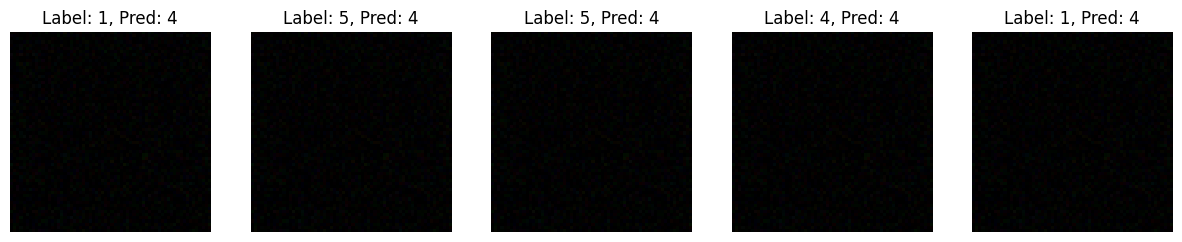

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the testing function
def test_attention_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())
    
    # Concatenate outputs and labels
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_outputs, all_labels

# Updated function to visualize results
def visualize_results(images, labels, outputs, num_images=5):
    # Convert outputs to predicted classes
    _, predicted = torch.max(outputs, 1)

    # Plot the images and predicted labels
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())  # Move to CPU and convert to HWC format
        plt.title(f'Label: {labels[i].item()}, Pred: {predicted[i].item()}')
        plt.axis('off')
    
    plt.show()

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attention_model = AttentionModel(num_classes=6).to(device)
attention_model.load_state_dict(torch.load("best_model_CustomVGGWithAttention.pt"))
attention_model.eval()

# Create DataLoader for test set (e.g., synthetic dataset)
test_dataloader = DataLoader(synthetic_dataset, batch_size=4, shuffle=False)

# Test the model
outputs, labels = test_attention_model(attention_model, test_dataloader, device)

# Visualize some results
visualize_results(synthetic_imgs[:5], labels[:5], outputs, num_images=5)
